In [1]:
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
tf.compat.v1.disable_eager_execution()

from tensorflow import keras
# from tensorflow.keras import layers
import pandas as pd

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

# 调用GPU加速
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# --------------------------------------- #
#（1）获取数据集
# --------------------------------------- #
filepath = './data/BTC.csv'  # 数据集位置
data = pd.read_csv(filepath)
print(data.head())  # 查看前五行数据

Instructions for updating:
non-resource variables are not supported in the long term
         Date        Open        High         Low       Close    Volume
0  2015/11/15  333.050995  334.661987  317.489990  320.165985  44213100
1  2015/11/16  319.734985  331.626007  315.904999  330.751007  47980100
2  2015/11/17  330.362000  338.350006  329.614014  335.093994  51001600
3  2015/11/18  334.592987  336.531006  330.640015  334.589996  43783800
4  2015/11/19  334.678986  335.334015  325.273010  326.148987  45011100


In [2]:
# 窗口划分
def split_windows(data, size):
    X = []
    Y = []
    for i in range(len(data) - size):
        X.append(data[i:i+size, :])
        Y.append(data[i+size, 2])
    return np.array(X), np.array(Y)

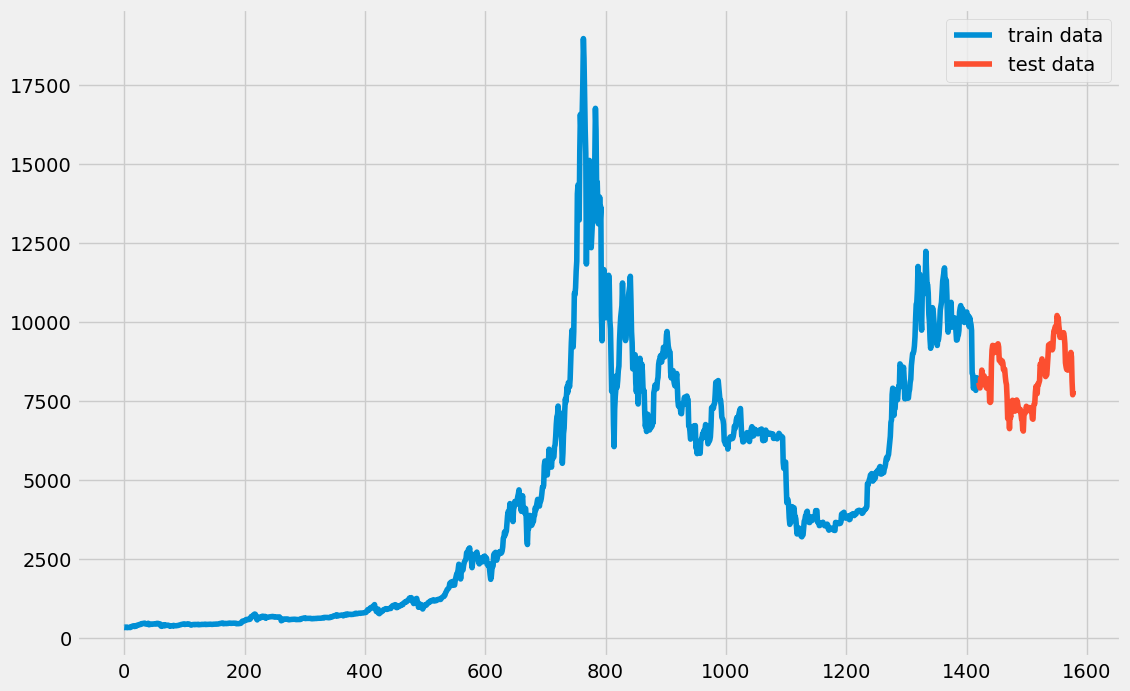

In [3]:
df = pd.read_csv('./data/BTC.csv', usecols=['Open', 'High','Low','Close','Volume'])
all_data = df.values
train_len = int(len(all_data)*0.9)
train_data = all_data[:train_len, :]
test_data = all_data[train_len:, :]
 
 
plt.figure(figsize=(12, 8))
plt.plot(np.arange(train_data.shape[0]), train_data[:, 2], label='train data')
plt.plot(np.arange(train_data.shape[0], train_data.shape[0] + test_data.shape[0]), test_data[:, 2], label='test data')
plt.legend()

In [4]:
# 归一化数据
scaler = MinMaxScaler()
scaled_train_data = scaler.fit_transform(train_data)
scaled_test_data = scaler.transform(test_data)
# 训练集测试集划分
window_size = 5
train_X, train_Y = split_windows(scaled_train_data, size=window_size)
test_X, test_Y = split_windows(scaled_test_data, size=window_size)
print('train shape', train_X.shape, train_Y.shape)
print('test shape', test_X.shape, test_Y.shape)

train shape (1415, 5, 5) (1415,)
test shape (153, 5, 5) (153,)


In [5]:
#模型搭建
window_size = 5
fea_num = 5
 
 
model = keras.models.Sequential([
    keras.layers.Input((window_size, fea_num)),
    keras.layers.Reshape((window_size, fea_num, 1)),
    keras.layers.Conv2D(filters=64,
                           kernel_size=3,
                           strides=1,
                           padding="same",
                           activation="relu"),
    keras.layers.MaxPooling2D(pool_size=2, strides=1, padding="same"),
    keras.layers.Dropout(0.3),
    keras.layers.Reshape((window_size, -1)),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.LSTM(64, return_sequences=False),
    keras.layers.Dense(32, activation="relu"),
    keras.layers.Dense(1)
])
 
 
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape (Reshape)           (None, 5, 5, 1)           0         
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 5, 5, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 5, 5, 64)          0         
                                                                 
 reshape_1 (Reshape)         (None, 5, 320)            0         
                                                                 
 lstm (LSTM)                 (None, 5, 128)            229888    
                                                        

In [6]:
history=model.fit(x=train_X, y=train_Y, epochs=700,batch_size=36,validation_split=0.1,verbose=1)

Train on 1273 samples, validate on 142 samples
Epoch 1/700
  36/1273 [..............................] - ETA: 4s - loss: 0.0859 - mean_squared_error: 0.0859

2023-07-20 17:49:04.060639: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:353] MLIR V1 optimization pass is not enabled
2023-07-20 17:49:04.065996: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-07-20 17:49:04.079417: W tensorflow/c/c_api.cc:300] Operation '{name:'training/Adam/conv2d/bias/m/Assign' id:1171 op device:{requested: '', assigned: ''} def:{{{node training/Adam/conv2d/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/conv2d/bias/m, training/Adam/conv2d/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1273/1273 [==============================] - 0s 291us/sample - loss: 0.0087 - mean_squared_error: 0.0087 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 2/700
 612/1273 [=============>................] - ETA: 0s - loss: 7.4233e-04 - mean_squared_error: 7.4233e-04

/Users/joey/anaconda3/envs/py38/lib/python3.8/site-packages/keras/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates
2023-07-20 17:49:04.442815: W tensorflow/c/c_api.cc:300] Operation '{name:'loss/mul' id:465 op device:{requested: '', assigned: ''} def:{{{node loss/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](loss/mul/x, loss/dense_1_loss/value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


1273/1273 [==============================] - 0s 189us/sample - loss: 7.6208e-04 - mean_squared_error: 7.6208e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 3/700
1273/1273 [==============================] - 0s 197us/sample - loss: 6.2059e-04 - mean_squared_error: 6.2059e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 4/700
1273/1273 [==============================] - 0s 206us/sample - loss: 6.7329e-04 - mean_squared_error: 6.7329e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 5/700
1273/1273 [==============================] - 0s 206us/sample - loss: 6.4981e-04 - mean_squared_error: 6.4981e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 6/700
1273/1273 [==============================] - 0s 209us/sample - loss: 6.2983e-04 - mean_squared_error: 6.2983e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 7/700
1273/1273 [==============================] - 0s 208us/sample - loss: 5.8398e-04 - mean_squared_error: 5.8398e-04 - 

1273/1273 [==============================] - 0s 211us/sample - loss: 3.4128e-04 - mean_squared_error: 3.4128e-04 - val_loss: 5.2274e-04 - val_mean_squared_error: 5.2274e-04
Epoch 48/700
1273/1273 [==============================] - 0s 213us/sample - loss: 2.4194e-04 - mean_squared_error: 2.4194e-04 - val_loss: 5.4266e-04 - val_mean_squared_error: 5.4266e-04
Epoch 49/700
1273/1273 [==============================] - 0s 210us/sample - loss: 2.9849e-04 - mean_squared_error: 2.9849e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 50/700
1273/1273 [==============================] - 0s 213us/sample - loss: 4.5899e-04 - mean_squared_error: 4.5899e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 51/700
1273/1273 [==============================] - 0s 211us/sample - loss: 3.3582e-04 - mean_squared_error: 3.3582e-04 - val_loss: 5.8237e-04 - val_mean_squared_error: 5.8237e-04
Epoch 52/700
1273/1273 [==============================] - 0s 212us/sample - loss: 2.7038e-04 - mean

Epoch 92/700
1273/1273 [==============================] - 0s 217us/sample - loss: 2.7586e-04 - mean_squared_error: 2.7586e-04 - val_loss: 4.9691e-04 - val_mean_squared_error: 4.9691e-04
Epoch 93/700
1273/1273 [==============================] - 0s 227us/sample - loss: 3.2487e-04 - mean_squared_error: 3.2487e-04 - val_loss: 5.9734e-04 - val_mean_squared_error: 5.9734e-04
Epoch 94/700
1273/1273 [==============================] - 0s 217us/sample - loss: 2.8696e-04 - mean_squared_error: 2.8696e-04 - val_loss: 8.4215e-04 - val_mean_squared_error: 8.4215e-04
Epoch 95/700
1273/1273 [==============================] - 0s 211us/sample - loss: 2.6484e-04 - mean_squared_error: 2.6484e-04 - val_loss: 3.9996e-04 - val_mean_squared_error: 3.9996e-04
Epoch 96/700
1273/1273 [==============================] - 0s 226us/sample - loss: 3.4450e-04 - mean_squared_error: 3.4450e-04 - val_loss: 9.6213e-04 - val_mean_squared_error: 9.6213e-04
Epoch 97/700
1273/1273 [==============================] - 0s 249us/sam

1273/1273 [==============================] - 0s 265us/sample - loss: 2.2193e-04 - mean_squared_error: 2.2193e-04 - val_loss: 4.8005e-04 - val_mean_squared_error: 4.8005e-04
Epoch 137/700
1273/1273 [==============================] - 0s 262us/sample - loss: 2.4246e-04 - mean_squared_error: 2.4246e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 138/700
1273/1273 [==============================] - 0s 265us/sample - loss: 2.8578e-04 - mean_squared_error: 2.8578e-04 - val_loss: 8.0780e-04 - val_mean_squared_error: 8.0780e-04
Epoch 139/700
1273/1273 [==============================] - 0s 260us/sample - loss: 2.5523e-04 - mean_squared_error: 2.5523e-04 - val_loss: 9.8831e-04 - val_mean_squared_error: 9.8831e-04
Epoch 140/700
1273/1273 [==============================] - 0s 259us/sample - loss: 3.4842e-04 - mean_squared_error: 3.4842e-04 - val_loss: 4.9974e-04 - val_mean_squared_error: 4.9974e-04
Epoch 141/700
1273/1273 [==============================] - 0s 262us/sample - loss: 2.25

1273/1273 [==============================] - 0s 221us/sample - loss: 3.8869e-04 - mean_squared_error: 3.8869e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 181/700
1273/1273 [==============================] - 0s 217us/sample - loss: 2.7508e-04 - mean_squared_error: 2.7508e-04 - val_loss: 7.7970e-04 - val_mean_squared_error: 7.7970e-04
Epoch 182/700
1273/1273 [==============================] - 0s 214us/sample - loss: 2.2380e-04 - mean_squared_error: 2.2380e-04 - val_loss: 6.5440e-04 - val_mean_squared_error: 6.5440e-04
Epoch 183/700
1273/1273 [==============================] - 0s 219us/sample - loss: 2.9481e-04 - mean_squared_error: 2.9481e-04 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 184/700
1273/1273 [==============================] - 0s 220us/sample - loss: 2.2512e-04 - mean_squared_error: 2.2512e-04 - val_loss: 5.9526e-04 - val_mean_squared_error: 5.9526e-04
Epoch 185/700
1273/1273 [==============================] - 0s 214us/sample - loss: 2.2131e-04 -

1273/1273 [==============================] - 0s 220us/sample - loss: 2.0776e-04 - mean_squared_error: 2.0776e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 225/700
1273/1273 [==============================] - 0s 217us/sample - loss: 2.8484e-04 - mean_squared_error: 2.8484e-04 - val_loss: 6.4497e-04 - val_mean_squared_error: 6.4497e-04
Epoch 226/700
1273/1273 [==============================] - 0s 221us/sample - loss: 2.5525e-04 - mean_squared_error: 2.5525e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 227/700
1273/1273 [==============================] - 0s 218us/sample - loss: 2.1459e-04 - mean_squared_error: 2.1459e-04 - val_loss: 6.4287e-04 - val_mean_squared_error: 6.4287e-04
Epoch 228/700
1273/1273 [==============================] - 0s 219us/sample - loss: 2.0627e-04 - mean_squared_error: 2.0627e-04 - val_loss: 7.0458e-04 - val_mean_squared_error: 7.0458e-04
Epoch 229/700
1273/1273 [==============================] - 0s 219us/sample - loss: 2.0913e-04 -

1273/1273 [==============================] - 0s 222us/sample - loss: 1.9532e-04 - mean_squared_error: 1.9532e-04 - val_loss: 7.1135e-04 - val_mean_squared_error: 7.1135e-04
Epoch 269/700
1273/1273 [==============================] - 0s 223us/sample - loss: 2.1267e-04 - mean_squared_error: 2.1267e-04 - val_loss: 9.8882e-04 - val_mean_squared_error: 9.8882e-04
Epoch 270/700
1273/1273 [==============================] - 0s 226us/sample - loss: 2.2682e-04 - mean_squared_error: 2.2682e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 271/700
1273/1273 [==============================] - 0s 227us/sample - loss: 2.0631e-04 - mean_squared_error: 2.0631e-04 - val_loss: 6.1813e-04 - val_mean_squared_error: 6.1813e-04
Epoch 272/700
1273/1273 [==============================] - 0s 223us/sample - loss: 2.4031e-04 - mean_squared_error: 2.4031e-04 - val_loss: 6.6864e-04 - val_mean_squared_error: 6.6864e-04
Epoch 273/700
1273/1273 [==============================] - 0s 221us/sample - loss: 2.88

1273/1273 [==============================] - 0s 217us/sample - loss: 1.7226e-04 - mean_squared_error: 1.7226e-04 - val_loss: 7.8837e-04 - val_mean_squared_error: 7.8837e-04
Epoch 313/700
1273/1273 [==============================] - 0s 219us/sample - loss: 2.1547e-04 - mean_squared_error: 2.1547e-04 - val_loss: 6.5215e-04 - val_mean_squared_error: 6.5215e-04
Epoch 314/700
1273/1273 [==============================] - 0s 218us/sample - loss: 1.8156e-04 - mean_squared_error: 1.8156e-04 - val_loss: 7.3427e-04 - val_mean_squared_error: 7.3427e-04
Epoch 315/700
1273/1273 [==============================] - 0s 219us/sample - loss: 2.0980e-04 - mean_squared_error: 2.0980e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 316/700
1273/1273 [==============================] - 0s 219us/sample - loss: 2.1041e-04 - mean_squared_error: 2.1041e-04 - val_loss: 8.6959e-04 - val_mean_squared_error: 8.6959e-04
Epoch 317/700
1273/1273 [==============================] - 0s 218us/sample - loss: 2.14

1273/1273 [==============================] - 0s 227us/sample - loss: 2.0640e-04 - mean_squared_error: 2.0640e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 357/700
1273/1273 [==============================] - 0s 240us/sample - loss: 1.6605e-04 - mean_squared_error: 1.6605e-04 - val_loss: 7.6559e-04 - val_mean_squared_error: 7.6559e-04
Epoch 358/700
1273/1273 [==============================] - 0s 214us/sample - loss: 1.8429e-04 - mean_squared_error: 1.8429e-04 - val_loss: 8.1137e-04 - val_mean_squared_error: 8.1137e-04
Epoch 359/700
1273/1273 [==============================] - 0s 235us/sample - loss: 1.9105e-04 - mean_squared_error: 1.9105e-04 - val_loss: 9.0411e-04 - val_mean_squared_error: 9.0411e-04
Epoch 360/700
1273/1273 [==============================] - 0s 229us/sample - loss: 1.7150e-04 - mean_squared_error: 1.7150e-04 - val_loss: 9.9179e-04 - val_mean_squared_error: 9.9179e-04
Epoch 361/700
1273/1273 [==============================] - 0s 223us/sample - loss: 1.78

Epoch 401/700
1273/1273 [==============================] - 0s 217us/sample - loss: 1.7947e-04 - mean_squared_error: 1.7947e-04 - val_loss: 9.8147e-04 - val_mean_squared_error: 9.8147e-04
Epoch 402/700
1273/1273 [==============================] - 0s 217us/sample - loss: 1.6623e-04 - mean_squared_error: 1.6623e-04 - val_loss: 8.0648e-04 - val_mean_squared_error: 8.0648e-04
Epoch 403/700
1273/1273 [==============================] - 0s 222us/sample - loss: 1.9968e-04 - mean_squared_error: 1.9968e-04 - val_loss: 8.0524e-04 - val_mean_squared_error: 8.0524e-04
Epoch 404/700
1273/1273 [==============================] - 0s 220us/sample - loss: 1.8462e-04 - mean_squared_error: 1.8462e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 405/700
1273/1273 [==============================] - 0s 220us/sample - loss: 1.6607e-04 - mean_squared_error: 1.6607e-04 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 406/700
1273/1273 [==============================] - 0s 220us/sample - loss

Epoch 446/700
1273/1273 [==============================] - 0s 218us/sample - loss: 2.0200e-04 - mean_squared_error: 2.0200e-04 - val_loss: 7.5495e-04 - val_mean_squared_error: 7.5495e-04
Epoch 447/700
1273/1273 [==============================] - 0s 215us/sample - loss: 1.7912e-04 - mean_squared_error: 1.7912e-04 - val_loss: 9.1827e-04 - val_mean_squared_error: 9.1827e-04
Epoch 448/700
1273/1273 [==============================] - 0s 219us/sample - loss: 1.7088e-04 - mean_squared_error: 1.7088e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 449/700
1273/1273 [==============================] - 0s 219us/sample - loss: 1.7475e-04 - mean_squared_error: 1.7475e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 450/700
1273/1273 [==============================] - 0s 222us/sample - loss: 1.3998e-04 - mean_squared_error: 1.3998e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 451/700
1273/1273 [==============================] - 0s 221us/sample - loss: 1.6995

1273/1273 [==============================] - 0s 225us/sample - loss: 1.6444e-04 - mean_squared_error: 1.6444e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 492/700
1273/1273 [==============================] - 0s 221us/sample - loss: 2.5833e-04 - mean_squared_error: 2.5833e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 493/700
1273/1273 [==============================] - 0s 221us/sample - loss: 1.6786e-04 - mean_squared_error: 1.6786e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 494/700
1273/1273 [==============================] - 0s 216us/sample - loss: 1.5635e-04 - mean_squared_error: 1.5635e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 495/700
1273/1273 [==============================] - 0s 220us/sample - loss: 1.7039e-04 - mean_squared_error: 1.7039e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 496/700
1273/1273 [==============================] - 0s 222us/sample - loss: 1.8656e-04 - mean_squared_error: 1.8

1273/1273 [==============================] - 0s 364us/sample - loss: 2.0622e-04 - mean_squared_error: 2.0622e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 537/700
1273/1273 [==============================] - 0s 207us/sample - loss: 2.2448e-04 - mean_squared_error: 2.2448e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 538/700
1273/1273 [==============================] - 0s 216us/sample - loss: 2.1498e-04 - mean_squared_error: 2.1498e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 539/700
1273/1273 [==============================] - 0s 219us/sample - loss: 1.3220e-04 - mean_squared_error: 1.3220e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 540/700
1273/1273 [==============================] - 0s 217us/sample - loss: 1.5983e-04 - mean_squared_error: 1.5983e-04 - val_loss: 9.9098e-04 - val_mean_squared_error: 9.9098e-04
Epoch 541/700
1273/1273 [==============================] - 0s 218us/sample - loss: 1.5577e-04 - mean_squared_er

1273/1273 [==============================] - 0s 243us/sample - loss: 1.5291e-04 - mean_squared_error: 1.5291e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 582/700
1273/1273 [==============================] - 0s 243us/sample - loss: 1.3532e-04 - mean_squared_error: 1.3532e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 583/700
1273/1273 [==============================] - 0s 244us/sample - loss: 1.8662e-04 - mean_squared_error: 1.8662e-04 - val_loss: 8.8067e-04 - val_mean_squared_error: 8.8067e-04
Epoch 584/700
1273/1273 [==============================] - 0s 242us/sample - loss: 1.5230e-04 - mean_squared_error: 1.5230e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 585/700
1273/1273 [==============================] - 0s 242us/sample - loss: 1.3818e-04 - mean_squared_error: 1.3818e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 586/700
1273/1273 [==============================] - 0s 240us/sample - loss: 1.4767e-04 - mean_squared_er

1273/1273 [==============================] - 0s 245us/sample - loss: 1.2282e-04 - mean_squared_error: 1.2282e-04 - val_loss: 9.0877e-04 - val_mean_squared_error: 9.0877e-04
Epoch 627/700
1273/1273 [==============================] - 0s 244us/sample - loss: 1.4301e-04 - mean_squared_error: 1.4301e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 628/700
1273/1273 [==============================] - 0s 237us/sample - loss: 1.3875e-04 - mean_squared_error: 1.3875e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 629/700
1273/1273 [==============================] - 0s 241us/sample - loss: 1.3902e-04 - mean_squared_error: 1.3902e-04 - val_loss: 9.9560e-04 - val_mean_squared_error: 9.9560e-04
Epoch 630/700
1273/1273 [==============================] - 0s 240us/sample - loss: 1.2697e-04 - mean_squared_error: 1.2697e-04 - val_loss: 8.8780e-04 - val_mean_squared_error: 8.8780e-04
Epoch 631/700
1273/1273 [==============================] - 0s 238us/sample - loss: 1.3597e-04 -

Epoch 671/700
1273/1273 [==============================] - 0s 242us/sample - loss: 1.7610e-04 - mean_squared_error: 1.7610e-04 - val_loss: 7.0435e-04 - val_mean_squared_error: 7.0435e-04
Epoch 672/700
1273/1273 [==============================] - 0s 242us/sample - loss: 1.6107e-04 - mean_squared_error: 1.6107e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 673/700
1273/1273 [==============================] - 0s 241us/sample - loss: 1.4462e-04 - mean_squared_error: 1.4462e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 674/700
1273/1273 [==============================] - 0s 242us/sample - loss: 1.3476e-04 - mean_squared_error: 1.3476e-04 - val_loss: 9.8996e-04 - val_mean_squared_error: 9.8996e-04
Epoch 675/700
1273/1273 [==============================] - 0s 240us/sample - loss: 1.6081e-04 - mean_squared_error: 1.6081e-04 - val_loss: 9.3908e-04 - val_mean_squared_error: 9.3908e-04
Epoch 676/700
1273/1273 [==============================] - 0s 239us/sample - loss

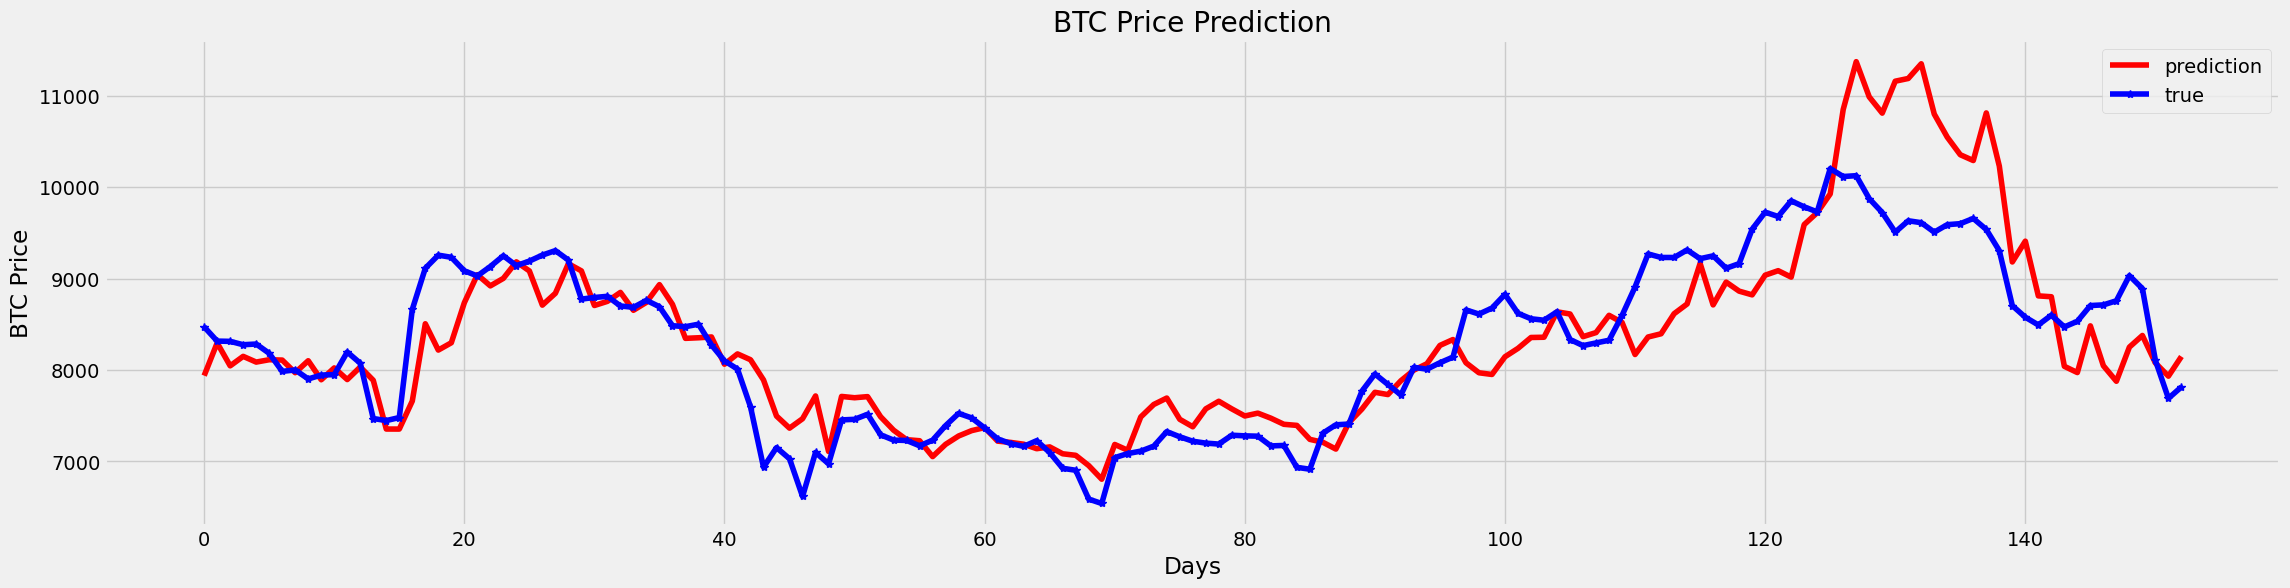

RMSE 513.0944999158238


In [42]:
prediction = model.predict(test_X)
scaled_prediction = prediction * (scaler.data_max_[2] - scaler.data_min_[2]) + scaler.data_min_[2]
scaled_true = test_Y * (scaler.data_max_[2] - scaler.data_min_[2]) + scaler.data_min_[2]
plt.figure(figsize=(25, 6))
plt.plot(range(len(scaled_prediction)), scaled_prediction, label='prediction',color='red', )
plt.plot(range(len(scaled_true)), scaled_true, label='true', marker='*',color='blue')
plt.legend(loc='best')
plt.title('BTC Price Prediction')
plt.xlabel('Days')
plt.ylabel('BTC Price')
plt.show()
 
 
from sklearn.metrics import mean_squared_error
print('RMSE', np.sqrt(mean_squared_error(scaled_prediction, scaled_true)))

In [43]:
pd.DataFrame(scaled_prediction).to_csv('./data/cnn_lstm_36_700.csv')
pd.DataFrame(scaled_true).to_csv('./data/real_price.csv')

In [44]:
from sklearn import metrics
y = scaled_true
y_hat = scaled_prediction
MSE = metrics.mean_squared_error(y, y_hat)
RMSE = metrics.mean_squared_error(y, y_hat)**0.5
MAE = metrics.mean_absolute_error(y, y_hat)
MAPE = metrics.mean_absolute_percentage_error(y, y_hat)
print("RMSE=", RMSE*100, '%')
print("MAPE=", MAPE*100, '%')
print("MSE=", MSE*100, '%')

RMSE= 51309.44999158238 %
MAPE= 4.311111298284464 %
MSE= 26326596.58438693 %


In [45]:
# 以 预测准确率=（预测正确样本数）/（总测试样本数）* 100% 对预测准确率进行计算，设定 ErrorTolerance = 5%
def accuracy(predict, true):
    sizeofall = len(true)
    sizeofright = 0
    for i in range(0, sizeofall):
        est = abs(predict[i] - true[i]) / true[i]
        if est < 0.05:
            sizeofright = sizeofright + 1

    return sizeofright/sizeofall
Ac = accuracy(scaled_prediction, scaled_true)
print("Accuracy=", Ac*100, '%')

Accuracy= 64.70588235294117 %


In [9]:
import shap   
# 初始化
shap.initjs()  

/Users/joey/anaconda3/envs/py38/lib/python3.8/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/Users/joey/anaconda3/envs/py38/lib/python3.8/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_

In [10]:
# Use the training data for deep explainer => can use fewer instances
explainer = shap.DeepExplainer(model, train_X)
# explain the the testing instances (can use fewer instanaces)
# explaining each prediction requires 2 * background dataset size runs
shap_values = explainer.shap_values(test_X)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [11]:
    # https://medium.com/@sakamoto2000.kim/applied-shap-on-the-polynomial-equation-case-with-lstm-algorithm-7c140d15736b
    shap_val = np.array(shap_values)
    a = np.absolute(shap_val[0])
    b = np.sum(a, axis=1)
    SHAP_list = [np.sum(b[:, 0]), np.sum(b[:, 1]), np.sum(b[:, 2]), np.sum(b[:, 3]), np.sum(b[:, 4])]
#     N_weight = normalize(weight_list)
#     N_SHAP = normalize(SHAP_list)
    print(SHAP_list)

[4.233672406903169, 4.827502870810502, 9.85042702002912, 6.852942381619464, 7.5772668654915405]


In [12]:
features = np.array(['BTC Open', 'BTC High','BTC Low','BTC Close','BTC Volume','ETH Price','XRP Price','LTC Price','Oil price','Gold Price','DJI Price'])
print(features)

['BTC Open' 'BTC High' 'BTC Low' 'BTC Close' 'BTC Volume' 'ETH Price'
 'XRP Price' 'LTC Price' 'Oil price' 'Gold Price' 'DJI Price']


In [16]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0], features)

In [17]:
shap.force_plot(explainer.expected_value, shap_values[0][0,:], test_X[0,:])

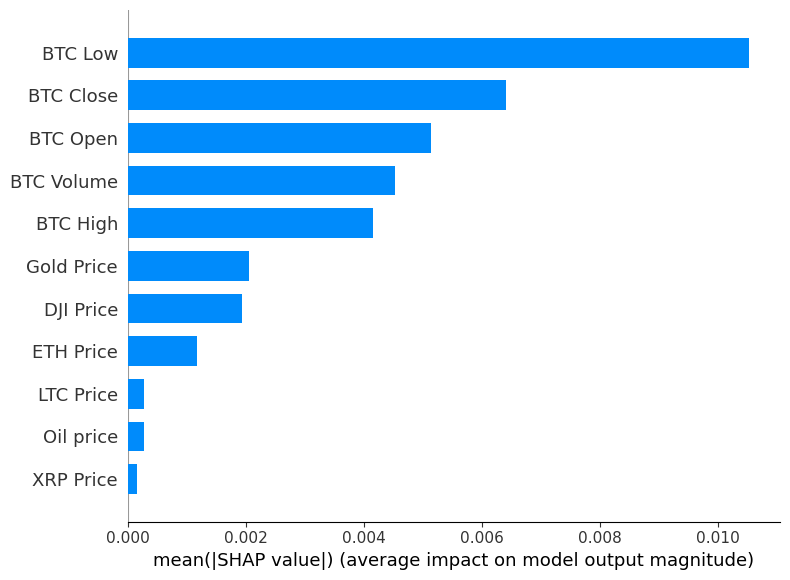

In [18]:
# shap.plots.bar(shap_values)
shap.summary_plot(shap_values[0][0], test_X[0], plot_type="bar",feature_names=features)

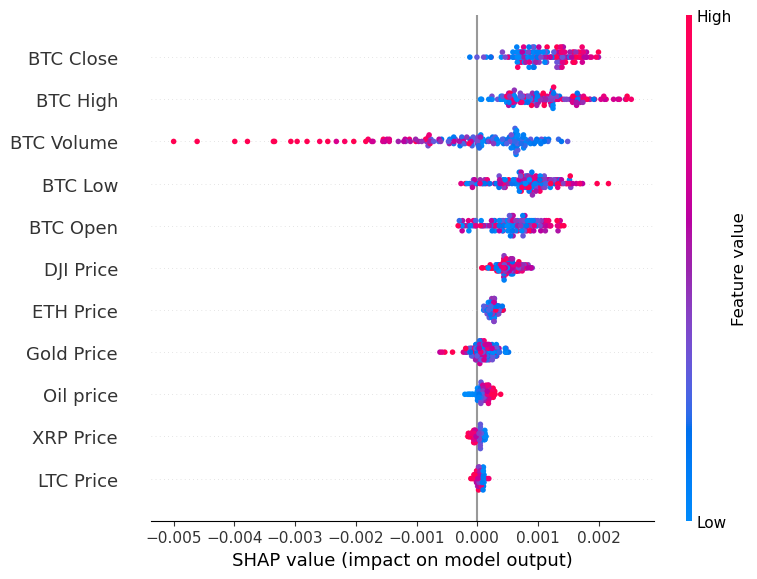

In [61]:
# shap.summary_plot(shap_values[0][0], test_X[0])
shap.summary_plot(shap_values[0][:, 0, :], test_X[:][:,0,:],feature_names=features,show=False)
plt.savefig("shap_summary_plot1.png",dpi=600)

In [65]:
shap.force_plot(explainer.expected_value[0], shap_values[0][0],feature_names=features)

In [44]:
# df1 = pd.DataFrame(shap_values[0][:, 1, :])
# df1.columns = features
# shap.plots.heatmap(df1)
# shap.plots.force(shap_values[0][:, 3, :])
# shap.force_plot(explainer.expected_value[0], shap_values[0][:, 3, :])
# shap.force_plot(explainer.expected_value, shap_values.values[0, :], X.iloc[0, :])
shap.force_plot(explainer.expected_value, shap_values[0][0,:], test_X[0,:],feature_names=features)

# shap.plots.scatter(shap_values[0][:,"BTC Low"], color=shap_values[0][:,"DIS"])

In [26]:
shap_values[0].shape
shap_values1 = np.reshape(shap_values[0],(-1,11))

test_X1 = np.reshape(test_X,(-1,11))
test_X1.shape
# shap_values1.shape
# shap.summary_plot(shap_values1, test_X1,feature_names=features)
shap.force_plot(explainer.expected_value, shap_values[0][10,:], test_X[10,:])


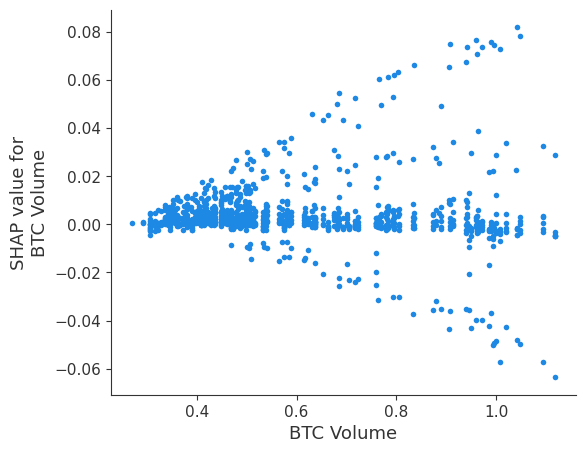

In [50]:
shap.dependence_plot('BTC Volume', shap_values1, test_X1, interaction_index=None,feature_names=features)

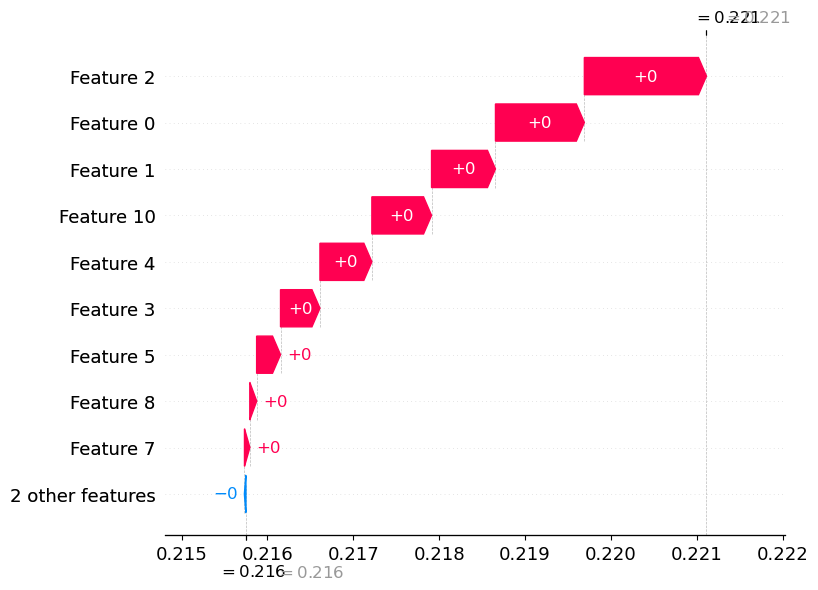

In [28]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0],shap_values1[0,:])

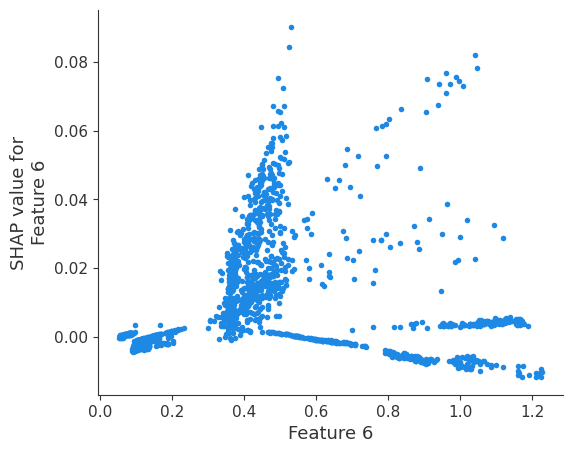

In [40]:
# shap.dependence_plot('Feature 3',shap_values[0][:, 1, :], test_X[:][:,1,:], interaction_index=None)
shap.dependence_plot('Feature 6',shap_values[0], test_X, interaction_index=None)

In [54]:
shap.summary_plot(shap_values1[0], test_X,feature_names=features)

AssertionError: Summary plots need a matrix of shap_values, not a vector.

In [52]:
shap_values[0].shape
# test_X.shape

(151, 7, 11)

In [72]:
test_X[0].shape

(7, 11)